# Santa Claus the Engineer!

In [42]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question:

Suppose Santa is trying to speed up the already quick present-giving process on Christmas Eve. Instead of going to the roof of every building on Olin's campus, he decides to land on West Hall and launch all his presents to the tops of the other four buildings. He has a launcher that can launch presents at any velocity and angle that he desires (because Santa is an engineer).

At what angle and final velocity will optimize Santa's needed force to launch his presents to all the other campus buildings?

In [43]:
#define units

m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
feet = UNITS.feet
inch = UNITS.inch
degree = UNITS.degree
N = UNITS.newton;

Here are the heights of Olin's five buildings, according to the building plans. We decided to set the height of West Hall as our origin to provide clarity.  We also assumed that the buildings are all at the same elevation to make our building plan-reading lives a little easier.

*Note: any variables pertaining to a building are assigned as "variable_building"*

In [44]:
height_WH = (53*feet + 1.625*inch).to(m) #16.196 m height of West Hall

height_EH = (67*feet).to(m) - height_WH #20.422 m height of East Hall
height_CC = (62*feet + 4* inch).to(m) - height_WH #18.992 m height of Campus Center
height_MH = (54*feet + 5.375*inch).to(m) - height_WH #15.596 m height of Milas Hall
height_AC =  (48*feet + 11.25*inch).to(m) - height_WH #14.916 m height of Academic Center

<Quantity(-1.2795249999999996, 'meter')>

... and the approximate distances between West Hall and the other four buildings (estimated using Google Maps).

In [45]:
to_EH = 80.88*m
to_MH = 108.69*m
to_AC = 141.29*m
to_CC = 72.69*m;

Now we need to create "params" and our System variable.  We'll start off by assuming Santa's launcher launches presents at a speed of 40m/s.

In [5]:
#create parameters
params = Params(x = 0 * m, 
                y = 0 * m,
                g = 9.81 * m/s**2,
                mass = 1.0206 * kg,
                height = 0.3048 * m,
                length = 0.3048 * m,
                width = 0.3048 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.8,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 100*s,
                h_end = 0*m,
                d_end = 10*m)

,values
x,0 meter
y,0 meter
g,9.81 meter / second ** 2
mass,1.0206 kilogram
height,0.3048 meter
length,0.3048 meter
width,0.3048 meter
rho,1.2 kilogram / meter ** 3
C_d,0.8
angle,45 degree


Now, we'll write functions that will create the system object, calculate the force of drag on the present, and compute the derivates of the state variables (like velocity and acceleration).

In [6]:
#create our system object

def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = height*length*height
    
    return System(params, init=init, area=area)

We also wrote drag and slope functions to update forces as the present moved through the air.

In [7]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [8]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

Next, we implement the measured data of the buildings and figure out what the optimal speed and angle are for Santa if he launched presents from West Hall to the other four buildings on campus. First, we'll create new *params* objects for each building in relation to West Hall.

In [41]:
params_EH = Params(params, h_end=height_EH, d_end=to_EH);
params_MH = Params(params, h_end=height_MH, d_end=to_MH);
params_AC = Params(params, h_end=height_AC, d_end=to_AC);
params_CC = Params(params, h_end=height_CC, d_end=to_CC);

We created *event_func*, which stops the solver when the projectile reaches the building. Then we wrote *height_func*, which calculates the height of the projectile when the it reaches the building.

In [10]:
def event_func(state, t, system):
    """Stop when the x coordinate is zero.
        When the object reaches the desired horizontal distance, the solver will end.
    
    state: State object
    t: time
    system: System object
    
    returns: x coordinate
    """
    unpack(system)
    x, y, vx, vy = state
    return x-d_end

def height_func(angle, params):  
    """Computes height for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: height in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    y_dist = get_last_value(results.y) * m
    return y_dist

In [11]:
#testing the height function to see if it works using hand-calculated values
height_func(38.59*degree, Params(params_EH, velocity = 48.9*m/s))

<Quantity(4.21740152548944, 'meter')>

We then created an *error_func* to calculate the difference between the final height of the projectile and the height of the building.  Since we wanted to save the measure of the angle at which the projectile was launched without explicitly returning it, we assign the angle measure to the **global** variable *opt_angle*. 

In [12]:
opt_angle = 45*degree
'''
opt_angle is a global variable. 

We are using it to temporarily store the optimal angle value so we can run the simulation of the present's trajectory
    after we solve for the optimal velocity.
'''

def error_func(v, params):
    """Finds the difference between the current height and the building height.
    
    v: Velocity variable
    params: Params object
    
    returns: difference in height in meters
    """
    
    this_params = Params(params, velocity=v)
    optimal_height = max_bounded(height_func, [0,90], this_params)
    global opt_angle
    opt_angle = optimal_height.x*degree
    height = optimal_height.fun
    return height - params.h_end

Now we calculate the optimal angle and velocity using *fsolve*.

In [13]:
res = fsolve(error_func, 45*m/s, params_EH);
v_EH = res[0]*m/s
angle_EH = opt_angle
print(v_EH, angle_EH)

48.903586728999755 meter / second 38.5945570483135 degree


In [14]:
params_EH = Params(params_EH, velocity=v_EH, angle=angle_EH)
system_EH = make_system(params_EH);
error_func(params_EH.velocity, params_EH)

<Quantity(-5.60440582830779e-13, 'meter')>

In [15]:
resultsEH, detailsEH = run_ode_solver(system_EH, slope_func, method="RK45",max_step = 0.5*s, events = event_func)
print(resultsEH)

                  x          y         vx         vy
0.000000   0.000000   0.000000  38.222052  30.506319
0.000029   0.001105   0.000882  38.221333  30.505461
0.000318   0.012157   0.009702  38.214136  30.496880
0.003210   0.122559   0.097768  38.142331  30.411235
0.032127   1.215321   0.964961  37.440232  29.570373
0.321303  11.164412   8.434329  31.723049  22.433285
0.821303  25.307000  17.295035  25.397709  13.538004
1.321303  36.949241  22.340782  21.444221   6.902563
1.821303  46.951916  24.388007  18.712035   1.428136
2.321303  55.768288  23.881398  16.629582  -3.362095
2.821303  63.635490  21.108846  14.875849  -7.649678
3.321303  70.669477  16.310611  13.277561 -11.462173
3.821303  76.926701   9.730686  11.763183 -14.771028
4.172724  80.880000   4.178707  10.742045 -16.782985


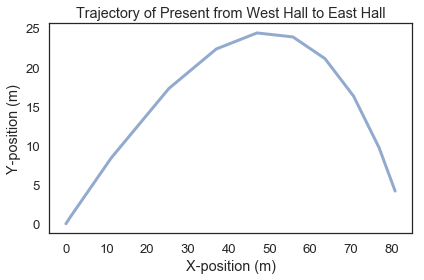

In [16]:
plot(resultsEH.x,resultsEH.y)
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Present from West Hall to East Hall',
         legend=False)

Now that we know that we were successful with launching presents to East Hall, we can repeat the process with the three other buildings on campus.

In [17]:
res2 = fsolve(error_func, 45*m/s, params_CC);
v_CC = res2[0]*m/s
angle_CC = opt_angle
print(v_CC, angle_CC)

43.177482027291745 meter / second 39.090930340504784 degree


In [18]:
params_CC = Params(params_CC, velocity=v_CC, angle=angle_CC)
system_CC = make_system(params_CC);
error_func(params_CC.velocity, params_CC)

<Quantity(-5.640146127916523e-10, 'meter')>

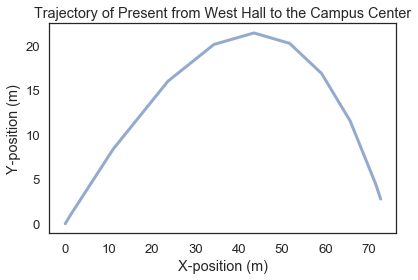

In [19]:
resultsCC, detailsCC = run_ode_solver(system_CC, slope_func, method="RK45", max_step=0.5*s, events = event_func)
detailsCC.message
plot(resultsCC.x, resultsCC.y)
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Present from West Hall to the Campus Center',
         legend=False)

In [20]:
res3 = fsolve(error_func, 45*m/s, params_MH);
v_MH = res3[0]*m/s
angle_MH = opt_angle
print(v_MH, angle_MH)

68.39087073698052 meter / second 34.51096663527482 degree


In [21]:
params_MH = Params(params_MH, velocity=v_MH, angle=angle_MH)
system_MH = make_system(params_MH)
error_func(params_MH.velocity, params_MH)

<Quantity(-2.4183921532028307e-09, 'meter')>

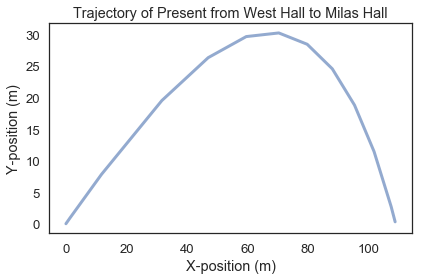

In [22]:
resultsMH, detailsMH = run_ode_solver(system_MH, slope_func, method="RK45", max_step=0.5*s, events = event_func)
detailsMH.message
plot(resultsMH.x, resultsMH.y)
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Present from West Hall to Milas Hall',
         legend=False)

In [31]:
res4 = fsolve(error_func, 45*m/s, params_AC);
v_AC = res4[0]*m/s
angle_AC = opt_angle
print(v_AC, angle_AC)

102.49559836574711 meter / second 31.027757597441195 degree


In [32]:
params_AC = Params(params, velocity=v_AC, angle=angle_AC, h_end=height_AC, d_end=to_AC)
system_AC = make_system(params_AC)
error_func(params_AC.velocity, params_AC)
print(params_AC)

x                                     0 meter
y                                     0 meter
g                    9.81 meter / second ** 2
mass                          1.0206 kilogram
height                           0.3048 meter
length                           0.3048 meter
width                            0.3048 meter
rho                 1.2 kilogram / meter ** 3
C_d                                       0.8
angle               31.027757597441195 degree
velocity    102.49559836574711 meter / second
t_end                              100 second
h_end               -1.2795249999999996 meter
d_end                            141.29 meter
dtype: object


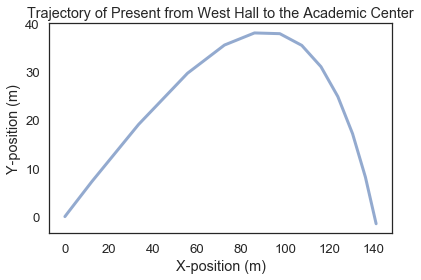

In [33]:
resultsAC, detailsAC = run_ode_solver(system_AC, slope_func, method="RK45", max_step=0.5*s, events = event_func)
detailsAC.message
plot(resultsAC.x, resultsAC.y)
decorate(xlabel='X-position (m)',
         ylabel='Y-position (m)',
         title='Trajectory of Present from West Hall to the Academic Center',
         legend=False)

In [34]:
def compute_force(params):
    """calculates force to push spring in imaginary present-launcher.
    
    params: Params object
    
    returns: force
    """
    unpack(params)
    
    k_constant = (mass * velocity**2) / (1*m**2)
    force_to_push_spring = k_constant * (1.0668*m) 
    return force_to_push_spring

In [35]:
force_EH = compute_force(params_EH).to(N)

<Quantity(2603.874187419104, 'newton')>

In [36]:
force_MH = compute_force(params_MH).to(N)

<Quantity(5092.544553452888, 'newton')>

In [37]:
force_CC = compute_force(params_CC).to(N)

<Quantity(2029.7997522162752, 'newton')>

In [38]:
force_AC = compute_force(params_AC).to(N)

<Quantity(11437.971270806436, 'newton')>